# **Data Science Hackathon: Stock Finance**
## Written by: Hamidreza Salahi
### 16 Oct 2024
## Email: salahi92.h@gmail.com

# Importing Libraries

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.offline as pox
import plotly.graph_objs as go
import seaborn as sns

import talib as ta

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import xgboost as xgb

import yfinance as yf

from datetime import datetime, timedelta
import pytz
import json

import csv


import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Importing Stock Data

In [290]:

tickers = ["ONCO", "CNEY", "TNXP", "APLD", "KTTA"]
#tickers = ["ONCO"]
end_date = datetime.strptime('2024-09-26', '%Y-%m-%d').date()
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d').date()


available_dates = {}

# Download stock data for each ticker and find the earliest date
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    if not df.empty:  # Check if data is available
        first_date = df.index.min().date()  # Get the earliest date
        available_dates[ticker] = first_date

# Find the latest start date that all tickers have data available
latest_start_date = max(available_dates.values()) if len(available_dates) == len(tickers) else None


print("Earliest available dates for each ticker:")
for ticker, date in available_dates.items():
    print(f"{ticker}: {date}")

if latest_start_date:
    print(f"\nLatest start date with available data for all tickers: {latest_start_date}")
else:
    print("\nNot all tickers have available data.")

    
    
# Download stock data
df = yf.download(tickers, start=latest_start_date, end=end_date, interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  5 of 5 completed

Earliest available dates for each ticker:
ONCO: 2022-02-18
CNEY: 2022-01-03
TNXP: 2022-01-03
APLD: 2022-04-13
KTTA: 2022-01-03

Latest start date with available data for all tickers: 2022-04-13


## Loading polarity dataframe from Sentiment Analysis obtained from Yahoo Conversation

In [291]:
# Load the file path mapping
with open('ticker_Pol_mapping.json', 'r') as json_file:
    csv_Pol_mapping = json.load(json_file)

# Load each CSV into a DataFrame and recreate the original dictionary
Pol_dfs = {}
for ticker, file_name in csv_Pol_mapping.items():
    Pol_dfs[ticker] = pd.read_csv(file_name,index_col=['date'])


# Feature Engineering

In [292]:
import pandas as pd
import talib as ta

def feature_engineering(ticker_df, Polarity_df):
    # Calculate future returns
    ticker_df['future_returns'] = ticker_df['Close'].pct_change().shift(-1)
    
    # Initialize the 'signal' column to 0
    ticker_df['signal'] = 0
    
    # Set 'signal' to 1 where future returns are positive
    ticker_df.loc[ticker_df['future_returns'] > 0, 'signal'] = 1

    # Calculate various technical indicators
    ticker_df['rsi14'] = ta.RSI(ticker_df['Close'].values, timeperiod=14)
    ticker_df['rsi10'] = ta.RSI(ticker_df['Close'].values, timeperiod=10)
    ticker_df['rsi30'] = ta.RSI(ticker_df['Close'].values, timeperiod=30)
    ticker_df['EMA12'] = ta.EMA(ticker_df['Close'].values, timeperiod=12)
    ticker_df['EMA16'] = ta.EMA(ticker_df['Close'].values, timeperiod=16)
    ticker_df['MACD_12_26'], ticker_df['MACD_Signal'], ticker_df['MACD_Hist'] = ta.MACD(ticker_df['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    ticker_df['Williams_R'] = ta.WILLR(high=ticker_df['High'], low=ticker_df['Low'], close=ticker_df['Close'], timeperiod=14)
    ticker_df['TR'] = ta.TRANGE(high=ticker_df['High'], low=ticker_df['Low'], close=ticker_df['Close'])
    ticker_df['ATR_14'] = ta.ATR(high=ticker_df['High'], low=ticker_df['Low'], close=ticker_df['Close'], timeperiod=14)
    ticker_df['CCI'] = ta.CCI(high=ticker_df['High'], low=ticker_df['Low'], close=ticker_df['Close'], timeperiod=20)
    ticker_df['adx'] = ta.ADX(ticker_df['High'].values, ticker_df['Low'].values, ticker_df['Open'].values, timeperiod=50)
    ticker_df['NATR'] = ta.NATR(ticker_df['High'], ticker_df['Low'], ticker_df["Close"], timeperiod=50)
    ticker_df['pct_change'] = ticker_df['Close'].pct_change()
    ticker_df['pct_change5'] = ticker_df['Close'].pct_change(5)
    ticker_df['pct_change10'] = ticker_df['Close'].pct_change(10)
    ticker_df['pct_change20'] = ticker_df['Close'].pct_change(20)
    ticker_df['pct_change30'] = ticker_df['Close'].pct_change(30)
    ticker_df['sma'] = ta.SMA(ticker_df['Close'], timeperiod=50)
    ticker_df['corr'] = ticker_df['Close'].rolling(window=int(6.5 * 4)).corr(ticker_df['sma'])
    ticker_df['Open-Close'] = (ticker_df["Open"] - ticker_df['Close']).shift(1)
    ticker_df['Close-High'] = (ticker_df["Close"] - ticker_df['High']).shift(1)
    ticker_df['Close-Low'] = (ticker_df["Close"] - ticker_df['Low']).shift(1)
    ticker_df['Close_Lag_1'] = ticker_df['Close'].shift(1)
    ticker_df['Close_Lag_2'] = ticker_df['Close'].shift(2)
    ticker_df['Momentum_20'] = ticker_df['Close'] - ticker_df['Close'].shift(20)
    
    # Drop 'future_returns' column
    ticker_df.drop(columns=['future_returns'], inplace=True)
    
    # Drop rows with NaN values after feature engineering
    ticker_df.dropna(inplace=True)  
    
    # Prepare the target and feature sets
    y = ticker_df[['signal']].copy()
#     X = ticker_df[['rsi10', 'rsi14', 'rsi30', 'EMA12', 'EMA16', 'MACD','Williams_R', 'TR', 'ATR', 'CCI',
#                    'adx', 'NATR', 'corr',
#                    'pct_change10', 'pct_change20', 'pct_change30', 'sma', 'Volume',
#                    'Open-Close', 'Close-Low', 'Close-High', 'Close_Lag_1', 
#                    'Close_Lag_2', 'Momentum_20']].copy()
    X = ticker_df[['rsi14','adx', 'NATR', 'corr','pct_change5', 'pct_change', 'sma', 'Volume','Open-Close',
                   'Close-Low', 'Close-High', 'Close_Lag_1', 'Close_Lag_2', 'Momentum_20', 'Close']].copy()
    X.rename_axis('date', inplace=True)
    X.index =pd.to_datetime(X.index,infer_datetime_format=True)
    X.index =pd.to_datetime(X.index.strftime("%m/%d/%y")).date
 #   X = pd.merge(X, Polarity_df, left_index=True, right_index=True)
    # Concatenate the two DataFrames along the columns (axis=1)
    df_concat = pd.concat([X, Polarity_df], axis = 1)

    # Slice the concatenated DataFrame to keep only rows corresponding to df1's dates
    X = df_concat.loc[X.index]
    return X, y


In [295]:
ticker_data = {}
ticker_data_all_features = {}
# Loop through each ticker and apply the feature engineering
for ticker in df.columns.levels[1]:  # Loop over the tickers in the second level of the MultiIndex
    # Extract data for the current ticker
    ticker_df = df.xs(ticker, axis=1, level=1)  # xs() extracts data by level in the MultiIndex
    Pol_df = Pol_dfs[ticker]
    Pol_df.index =pd.to_datetime(Pol_df.index,infer_datetime_format=True)
    Pol_df.index =pd.to_datetime(Pol_df.index.strftime("%m/%d/%y")).date
    # Perform feature engineering on the ticker's data
    X, y = feature_engineering(ticker_df, Pol_df)
    X['polarity'] = X['polarity'].fillna(0)
    X1, y1 = X.copy(), y.copy()
    # Store the X and y in the dictionary with the ticker as the key
    ticker_data[ticker] = (X, y)
    ticker_data_all_features[ticker] = (X1, y1)

# Correlation Check

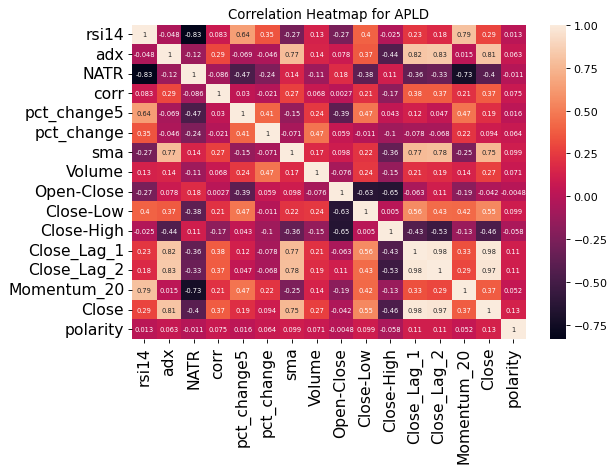

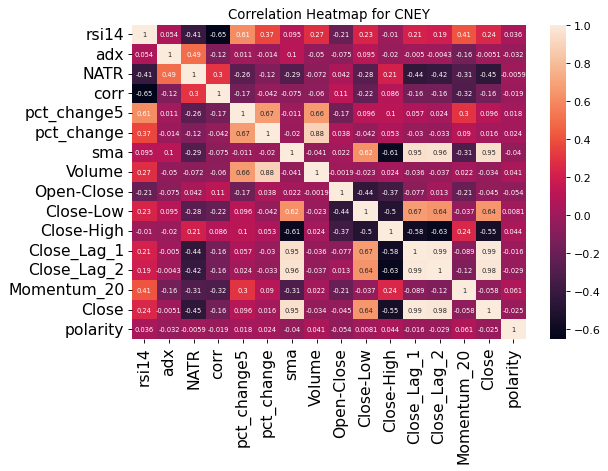

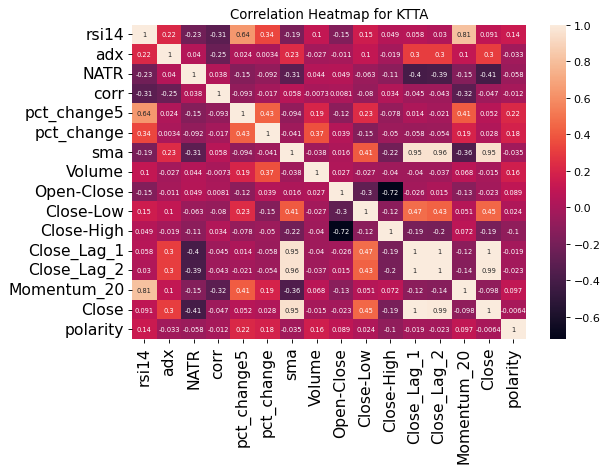

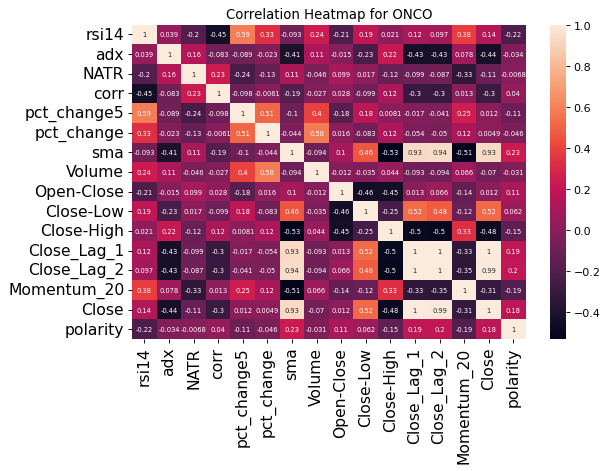

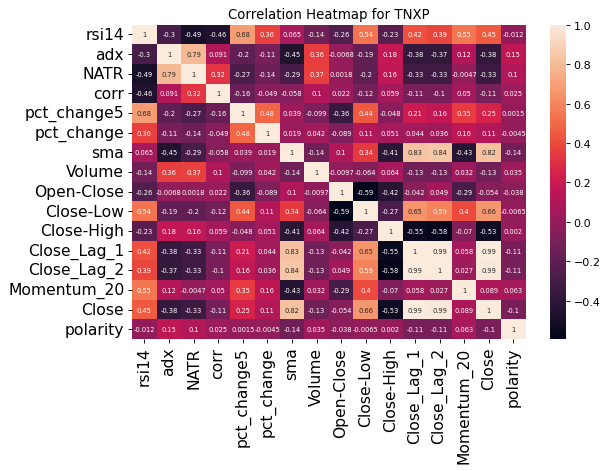

In [297]:
for ticker, (X, _) in ticker_data.items():
    # Create a copy of the features DataFrame
    z = X.copy()
    
    # Calculate the correlation matrix
    corr = z.corr()

    # Create the heatmap
    figure(figsize=(8, 6), dpi=80)
    sns.heatmap(corr, annot=True, annot_kws={"size": 6})
    plt.yticks(rotation=0, size=14)
    plt.xticks(rotation=90, size=14)
    plt.title(f'Correlation Heatmap for {ticker}')  # Add title for each ticker
    plt.tight_layout()  # Fits plot area to the plot, "tightly"
    
    # Show the plot
    plt.show()

In [298]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()
    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
   
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)
    
    return correl[correl > threshold].index

#  apply this function to all tickers in ticker_data
threshold = 0.7  
correlated_pairs_by_ticker = {}
for ticker, (X, y) in ticker_data.items():
    correlated_pairs = get_pair_above_threshold(X, threshold)
    correlated_pairs_by_ticker[ticker] = correlated_pairs  # Store the result for each ticker

# Print the correlated pairs for each ticker
for ticker, pairs in correlated_pairs_by_ticker.items():
    print(f"Ticker: {ticker}")
    print(pairs)
    print("-" * 40)

Ticker: APLD
MultiIndex([('Close_Lag_1', 'Close_Lag_2'),
            ('Close_Lag_1',       'Close'),
            ('Close_Lag_2',       'Close'),
            (      'rsi14',        'NATR'),
            (        'adx', 'Close_Lag_2'),
            (        'adx', 'Close_Lag_1'),
            (        'adx',       'Close'),
            (      'rsi14', 'Momentum_20'),
            (        'sma', 'Close_Lag_2'),
            (        'adx',         'sma'),
            (        'sma', 'Close_Lag_1'),
            (        'sma',       'Close'),
            (       'NATR', 'Momentum_20')],
           )
----------------------------------------
Ticker: CNEY
MultiIndex([('Close_Lag_1', 'Close_Lag_2'),
            ('Close_Lag_1',       'Close'),
            ('Close_Lag_2',       'Close'),
            (        'sma', 'Close_Lag_2'),
            (        'sma', 'Close_Lag_1'),
            (        'sma',       'Close'),
            ( 'pct_change',      'Volume')],
           )
-------------------------

In [299]:
def drop_highly_correlated_columns(X, threshold):
    """
    Function to drop columns with correlation above a specified threshold.
    """
    # 1. Compute the correlation matrix
    corr = X.corr()

    # 2. Create an upper triangle of the correlation matrix to avoid duplicate pairs
    upper_triangle = corr.where(np.triu(np.ones(corr.abs().shape), k=1).astype(bool))

    # 3. Find columns with correlation above the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # 4. Drop the highly correlated columns
    X_reduced = X.drop(columns=to_drop)
    
    return X_reduced, to_drop

#  apply this function to all tickers in ticker_data
threshold = 0.7  # correlation threshold
dropped_columns_by_ticker = {}

for ticker, (X, y) in ticker_data.items():
    X_reduced, to_drop = drop_highly_correlated_columns(X, threshold)
    ticker_data[ticker] = (X_reduced, y)  
    dropped_columns_by_ticker[ticker] = to_drop  # Store the dropped columns for each ticker

# Print the dropped columns for each ticker
for ticker, to_drop in dropped_columns_by_ticker.items():
    print(f"Ticker: {ticker}")
    print(f"Columns dropped: {to_drop}")
    print("-" * 40)

Ticker: APLD
Columns dropped: ['sma', 'Close_Lag_1', 'Close_Lag_2', 'Momentum_20', 'Close']
----------------------------------------
Ticker: CNEY
Columns dropped: ['Volume', 'Close_Lag_1', 'Close_Lag_2', 'Close']
----------------------------------------
Ticker: KTTA
Columns dropped: ['Close_Lag_1', 'Close_Lag_2', 'Momentum_20', 'Close']
----------------------------------------
Ticker: ONCO
Columns dropped: ['Close_Lag_1', 'Close_Lag_2', 'Close']
----------------------------------------
Ticker: TNXP
Columns dropped: ['NATR', 'Close_Lag_1', 'Close_Lag_2', 'Close']
----------------------------------------


# Stationary Check

In [300]:
def stationary(series):
    """
    Function to check if the series is stationary or not.
    Returns 'stationary' if p-value < 0.05, otherwise 'not stationary'.
    """
    result = adfuller(series)
    if result[1] < 0.05:
        return 'stationary'
    else:
        return 'not stationary'

def check_and_drop_non_stationary(X):
    """
    Function to check for stationarity for each column in X and drop non-stationary columns.
    """
    non_stationary_columns = []

    for col in X.columns:
        if stationary(X[col]) == 'not stationary':
            non_stationary_columns.append(col)
            print(f'{col} is not stationary. Dropping it.')
        else:
            print(f'{col} is stationary.')

    # Drop non-stationary columns
    X_cleaned = X.drop(columns=non_stationary_columns)
    return X_cleaned, non_stationary_columns

#  apply this function to all tickers in ticker_data
non_stationary_columns_by_ticker = {}

for ticker, (X, y) in ticker_data.items():
    X_cleaned, non_stationary_columns = check_and_drop_non_stationary(X)
    ticker_data[ticker] = (X_cleaned, y)  # Update ticker_data with cleaned X
    non_stationary_columns_by_ticker[ticker] = non_stationary_columns  # Store dropped columns

# Print the non-stationary columns for each ticker
for ticker, non_stationary_columns in non_stationary_columns_by_ticker.items():
    print(f"Ticker: {ticker}")
    print(f"Non-stationary columns dropped: {non_stationary_columns}")
    print("-" * 40)

rsi14 is stationary.
adx is not stationary. Dropping it.
NATR is stationary.
corr is stationary.
pct_change5 is stationary.
pct_change is stationary.
Volume is stationary.
Open-Close is stationary.
Close-Low is stationary.
Close-High is not stationary. Dropping it.
polarity is stationary.
rsi14 is stationary.
adx is not stationary. Dropping it.
NATR is not stationary. Dropping it.
corr is stationary.
pct_change5 is stationary.
pct_change is stationary.
sma is stationary.
Open-Close is stationary.
Close-Low is not stationary. Dropping it.
Close-High is not stationary. Dropping it.
Momentum_20 is stationary.
polarity is stationary.
rsi14 is stationary.
adx is not stationary. Dropping it.
NATR is not stationary. Dropping it.
corr is stationary.
pct_change5 is stationary.
pct_change is stationary.
sma is stationary.
Volume is stationary.
Open-Close is stationary.
Close-Low is stationary.
Close-High is stationary.
polarity is stationary.
rsi14 is stationary.
adx is not stationary. Dropping 

# Splitting and Training Model

In [301]:
def train_test_split_and_scale_tickers(ticker_data, split_percentage=0.8):
    """
    Function to split the data for each ticker into training and testing sets and apply StandardScaler.
    
    Parameters:
    - ticker_data: Dictionary where keys are tickers and values are (X, y) tuples.
    - split_percentage: Fraction of the data to be used for training (default is 0.8).
    
    Returns:
    - train_test_data: Dictionary with keys as tickers and values as (X_train_scaled, X_test_scaled, y_train, y_test) tuples.
    - scalers: Dictionary with tickers as keys and fitted StandardScaler for each ticker.
    """
    train_test_data = {}
    scalers = {}
    
    for ticker, (X, y) in ticker_data.items():
        split = int(split_percentage * len(X))  # Calculate split point
        
        # Train data
        X_train = X[:split]
        y_train = y[:split]
        
        # Test data
        X_test = X[split:]
        y_test = y[split:]
        
        # Initialize StandardScaler and fit on X_train
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        # Transform X_test using the fitted scaler
        X_test_scaled = scaler.transform(X_test)
        
        # Store the scaled data and scaler for the current ticker
        train_test_data[ticker] = (X_train_scaled, X_test_scaled, y_train, y_test)
        scalers[ticker] = scaler
    
    return train_test_data, scalers

# Apply the function to split and scale data for all tickers
train_test_data, scalers = train_test_split_and_scale_tickers(ticker_data, split_percentage=0.8)

# access the scaled train and test sets for each ticker
for ticker, (X_train_scaled, X_test_scaled, y_train, y_test) in train_test_data.items():
    print(f"Ticker: {ticker}")
    print(f"X_train_scaled shape: {X_train_scaled.shape}, X_test_scaled shape: {X_test_scaled.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
    print("-" * 40)


Ticker: APLD
X_train_scaled shape: (413, 9), X_test_scaled shape: (104, 9)
y_train shape: (413, 1), y_test shape: (104, 1)
----------------------------------------
Ticker: CNEY
X_train_scaled shape: (413, 8), X_test_scaled shape: (104, 8)
y_train shape: (413, 1), y_test shape: (104, 1)
----------------------------------------
Ticker: KTTA
X_train_scaled shape: (413, 10), X_test_scaled shape: (104, 10)
y_train shape: (413, 1), y_test shape: (104, 1)
----------------------------------------
Ticker: ONCO
X_train_scaled shape: (413, 10), X_test_scaled shape: (104, 10)
y_train shape: (413, 1), y_test shape: (104, 1)
----------------------------------------
Ticker: TNXP
X_train_scaled shape: (413, 9), X_test_scaled shape: (104, 9)
y_train shape: (413, 1), y_test shape: (104, 1)
----------------------------------------


In [302]:


# Define parameter grids for each model
param_grids = {
    'xgboost': {
        'model__max_depth': [3, 6, 9, 12, None],
        'model__learning_rate': [0.01, 0.1, 0.2, 0.3, None],
        'model__n_estimators': [10, 50, 100, 200, None],
        'model__subsample': [0.8, 1.0, None],       
        'model__colsample_bytree': [0.8, 1.0, None], 
    },
    'randomforest': {
        'model__n_estimators': [10, 50, 100, 150, 200],
        'model__max_depth': [None, 3, 5, 8, 10],
        'model__min_samples_split': [2, 5, 8, 10],
        'model__min_samples_leaf': [1, 2, 3, 4],
        'model__max_features': ['auto', 'sqrt']
    },
    'decisiontree': {
        'model__max_depth': [None, 3, 5, 10],
        'model__min_samples_split': [2, 5, 8, 10],
        'model__min_samples_leaf': [1, 2, 3, 4]
    }
}

# Initialize a results dictionary to store accuracy and ROC AUC for each ticker
results = {}
classification_reports = {}
best_models = {}
# Loop through each ticker
for ticker, (X_train_scaled, X_test_scaled, y_train, y_test) in train_test_data.items():
    print(f"Processing {ticker}...")

    
    # Initialize results for this ticker
    ticker_results = {}

    # Define the models to evaluate
    models = {
        'XGBoost': xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42)
    }
    # Store the best ROC AUC and the corresponding model
    best_roc_auc = 0
    best_model_name = None
    best_model_ticker = None
    # Loop through each model and perform GridSearchCV
    for model_name, model in models.items():
        print(f"Training {model_name} model...")
        
        # Create a pipeline with the scaler and the model
        pipeline = Pipeline([
           
            ('model', model)
        ])
        
        # Set up GridSearchCV for the model
        grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=param_grids[model_name.lower().replace(' ', '_')],
                                   scoring='roc_auc',  # Use ROC AUC for scoring
                                   cv=5,               # 5-fold cross-validation
                                   verbose=1,
                                   n_jobs=-1)          # Use all available cores

        # Train the model with GridSearchCV
        grid_search.fit(X_train_scaled, y_train['signal'])

        # Make predictions using the best model
        best_model = grid_search.best_estimator_
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]  # Get the predicted probabilities for the positive class
        y_pred = best_model.predict(X_test_scaled)

        # Evaluate the model
        roc_auc = roc_auc_score(y_test['signal'], y_pred_proba)
        accuracy = accuracy_score(y_test['signal'], y_pred)
                # Check if this is the best model
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_model_name = model_name
            best_model_ticker = best_model

        # Store the best model for the current ticker
        best_models[ticker] = (best_model_name, best_model_ticker, best_roc_auc)
        # Store the results for this model
        ticker_results[model_name] = (accuracy, roc_auc)
        print(f"{model_name} Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

    # Store results for this ticker
    results[ticker] = ticker_results

# Print results for all tickers
for ticker, ticker_result in results.items():
    print(f"\nResults for {ticker}:")
    for model_name, metrics in ticker_result.items():
        print(f"{model_name} - Accuracy: {metrics[0]:.4f}, ROC AUC: {metrics[1]:.4f}")


Processing APLD...
Training XGBoost model...
Fitting 5 folds for each of 1125 candidates, totalling 5625 fits
XGBoost Accuracy: 0.4904, ROC AUC: 0.5950
Training RandomForest model...
Fitting 5 folds for each of 800 candidates, totalling 4000 fits
RandomForest Accuracy: 0.6058, ROC AUC: 0.5950
Training DecisionTree model...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
DecisionTree Accuracy: 0.5577, ROC AUC: 0.5364
Processing CNEY...
Training XGBoost model...
Fitting 5 folds for each of 1125 candidates, totalling 5625 fits
XGBoost Accuracy: 0.5673, ROC AUC: 0.6244
Training RandomForest model...
Fitting 5 folds for each of 800 candidates, totalling 4000 fits
RandomForest Accuracy: 0.5673, ROC AUC: 0.6081
Training DecisionTree model...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
DecisionTree Accuracy: 0.5673, ROC AUC: 0.5807
Processing KTTA...
Training XGBoost model...
Fitting 5 folds for each of 1125 candidates, totalling 5625 fits
XGBoost Accuracy: 0.63

In [303]:
results_df = pd.DataFrame.from_dict({ticker: {model: metrics[1] for model, metrics in ticker_result.items()} 
                                        for ticker, ticker_result in results.items()},
                                     orient='index')

# Display the DataFrame with bold formatting for the highest ROC AUC values
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

styled_results_df = results_df.style.apply(highlight_max, axis=1)

# Display the styled DataFrame
styled_results_df

,XGBoost,RandomForest,DecisionTree
APLD,0.594991,0.594991,0.536364
CNEY,0.624402,0.608054,0.580742
KTTA,0.643064,0.658799,0.684472
ONCO,0.545056,0.629984,0.614035
TNXP,0.468045,0.574718,0.527256
